In [12]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Autoencoders [1]

An **autoencoder** is a neural network trained to attempt to copy its input to its output. The network consists of two parts:
* an *encoder* function $\mathbf{h} = f\left(\mathbf{x}\right)$ and
* a *decoder*, which reconstructs the input $\mathbf{r} = g\left(\mathbf{h}\right)$.

An autoencoder mapps the input $\mathbf{x}$ to an output $\mathbf{r}$  through an internal representation or code $\mathbf{h}$.

![ae.png](assets/ae.png)

We can see autoencoders as a method of dimensionality reduction: the encoder produces "new features" representation from the input data, and the decoder performs a reverse process. Here, the main purpose is to find the best encoder-decoder pair, that keeps the maximum information when encoding, and hence, has the minimum of reconstruction error $\mathcal{L}$.

$$\left(f^*, g^*\right) = \arg \min \mathcal{L}\left(x, g\left(f\left(\mathbf{x}\right)\right)\right)$$

In case of autoencoders, the most commonly used loss function is mean squared error. The overall model is trained jointly (encoder + decoder) by minimizing the reconstruction error with gradient descent over the parameters of these networks.

Usually, we would like an autoencoder to copy input only approximately, so that it prioritizes which aspects of the input should be copied. This way it is able to learn useful properties of the data. If an autoencoder learns to set $g\left(f\left(\mathbf{x}\right)\right)=\mathbf{x}$ everywhere, then it is not especially useful.

Traditionally, autoencoders were used for dimensionality reduction or feature learning. Autoencoders can be viewed as an example of a feedforward network, and therefore may be trained with all the same techniques, such as minibatch gradient descent and backpropagation. However, with no labels taken into consideration, training autoencoders might be seen as an example of **unsupervised learning**.

> [[1] Goodfellow, I., Bengio, Y., Courville, A. *Deep Learning*. 2016.](https://www.deeplearningbook.org/contents/autoencoders.html)


## Implement a simple autoencoder with `pytorch`

As earlier, before hitting more advanced models, we will start with a vanilla autoencoder.
 We will be implementing a simple encoder-decoder model using `pytorch` to learn to reconstruct
 handwritten digits

### Data

Once again, we will be working with MNIST daaset of handwritten digits, where each image
 is of size $28 \times 28$, with values in range $\left[0, 255\right]$.

![mnist](https://cdn-images-1.medium.com/max/800/0*At0wJRULTXvyA3EK.png)

In [13]:
import torch
import torch.nn as nn
from IPython.display import Code, display

from src.ae import BaseAutoEncoder


### Implementing Encoder and Decoder networks

In [14]:
class Encoder(nn.Module):
    """Encoder module; function h."""

    def __init__(
            self,
            n_input_features: int,
            n_hidden_neurons: int,
            n_latent_features: int,
    ):
        """
        :param n_input_features: number of input features (28 x 28 = 784 for MNIST)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_latent_features: size of the latent vector
        """
        super().__init__()

        self.layer_input_to_hidden = nn.Linear(n_input_features, n_hidden_neurons)
        self.layer_hidden_to_latent = nn.Linear(n_hidden_neurons, n_latent_features)
        self.nonlinear = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Encoder forward function."""
        h = self.layer_input_to_hidden(x)
        h = self.nonlinear(h)
        h = self.layer_hidden_to_latent(h)
        h = self.nonlinear(h)
        return h


In [15]:
class Decoder(nn.Module):
    """Decoder module; function g."""

    def __init__(
            self,
            n_latent_features: int,
            n_hidden_neurons: int,
            n_output_features: int,
    ):
        """
        :param n_latent_features: number of latent features (same as in Encoder)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_output_features: size of the output vector (28 x 28 = 784 for MNIST)
        """
        super().__init__()

        self.layer_latent_to_hidden = nn.Linear(n_latent_features, n_hidden_neurons)
        self.hidden_nonlinear = nn.Tanh()
        self.layer_hidden_to_output = nn.Linear(n_hidden_neurons, n_output_features)
        self.output_nonlinear = nn.Sigmoid()

    def forward(self, h: torch.Tensor) -> torch.Tensor:
        """Decoder forward function."""
        r = self.layer_latent_to_hidden(h)
        r = self.hidden_nonlinear(r)
        r = self.layer_hidden_to_output(r)
        r = self.output_nonlinear(r)
        return r


### Implementing the Autoencoder

We will be basing our code on the following base class to fulfill analysis requirements.


In [16]:
display(Code(filename="src/ae.py"))


import torch
import torch.nn as nn


class BaseAutoEncoder(nn.Module):
    """Base AutoEncoder module class."""

    def __init__(self, encoder: nn.Module, decoder: nn.Module, n_latent_features: int):
        """
        :param encoder: encoder network
        :param decoder: decoder network
        :param n_latent_features: number of latent features in the AE
        """
        super().__init__()

        self.n_latent_features: int = n_latent_features

        self.encoder: nn.Module = encoder
        self.decoder: nn.Module = decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward function for mapping input to output."""
        z = self.encoder_forward(x)
        return self.decoder_forward(z)

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Function to perform forward pass through encoder network.

        takes: tensor of shape [batch_size x input_flattened_size] (flattened input)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """

        raise self.encoder.forward(x)  # NotImplementedError()

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """ Function to perform forward pass through decoder network.

        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x output_flattened_size] (flettened output)
        """
        raise self.decoder.forward(x)  # NotImplementedError()

In [17]:
class AutoEncoder(BaseAutoEncoder):
    """AutoEncoder module."""

    def __init__(
            self,
            n_data_features: int,
            n_encoder_hidden_features: int,
            n_decoder_hidden_features: int,
            n_latent_features: int,
    ):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        """        
        encoder = Encoder(
            n_input_features=n_data_features,
            n_hidden_neurons=n_encoder_hidden_features,
            n_latent_features=n_latent_features
        )
        decoder = Decoder(
            n_latent_features=n_latent_features,
            n_hidden_neurons=n_decoder_hidden_features,
            n_output_features=n_data_features
        )
        super().__init__(
            encoder=encoder,
            decoder=decoder,
            n_latent_features=n_latent_features
        )
    
    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network."""
        return self.encoder(x)
    
    def decoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network."""
        return self.decoder(x)


### Loading data

In [18]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm.notebook import tqdm, trange

np.random.seed(0)


In [20]:
train_dataset = MNIST(
    root="data",
    download=True,
    train=True,
    transform=ToTensor()  # converts numpy form to torch tensor in range [0, 1]
)
test_dataset = MNIST(
    root="data",
    download=True,
    train=False,
    transform=ToTensor()
)

# limiting the dataset
indices = np.random.permutation(len(train_dataset.data))[:10_000]
train_dataset.data = train_dataset.data[indices]
train_dataset.targets = train_dataset.targets[indices]


In [21]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False
)


### Model initialization and training

As a toy example, we will be training an autoencoder with 128 hidden neurons in both
 encoder and decoder, and a 16-dimension latent space. This cannot lead to a good reconstruction
 performance, but will serve well in case of further analysis. Of course, the number
 of latent features might be increased.
 

In [22]:
model = AutoEncoder(
    n_data_features=28 * 28,  # MNIST pixels
    n_encoder_hidden_features=128,  # chosen arbitrarily
    n_decoder_hidden_features=128,  # chosen arbitrarily
    n_latent_features=20  # how many features will be used to represent input
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-2,
)


In [23]:
epochs = 20
train_metrics = {
    "loss": [],
    "step": [],
}
test_metrics = {
    "loss": [],
    "step": [],
}

global_step = 0

for epoch in trange(epochs):
    print(f"Epoch: {epoch + 1} / {epochs}.")

    # training step
    model.train()
    pbar = tqdm(train_dataloader)
    for inputs, _ in pbar:  # we are not using labels for training
        optimizer.zero_grad()
        inputs = inputs.view((-1, 28 * 28))
        reconstructions = model(inputs)

        loss = loss_fn(reconstructions, inputs)
        loss.backward()

        optimizer.step()

        train_metrics["loss"].append(loss.item())
        train_metrics["step"].append(global_step)

        global_step += 1
        pbar.update(1)
    pbar.close()

    # validation step
    model.eval()

    ins = []
    recs = []

    for inputs, _ in test_loader:
        inputs = inputs.view((-1, 28 * 28))
        reconstructions = model(inputs)
        ins.append(inputs)
        recs.append(reconstructions)

    ins = torch.cat(ins, dim=0)
    recs = torch.cat(recs, dim=0)

    val_loss = loss_fn(ins, recs)
    test_metrics["loss"].append(val_loss.item())
    test_metrics["step"].append(global_step)


Epoch: 1 / 20.



Epoch: 2 / 20.



Epoch: 3 / 20.



Epoch: 4 / 20.



Epoch: 5 / 20.



Epoch: 6 / 20.



Epoch: 7 / 20.



Epoch: 8 / 20.



Epoch: 9 / 20.



Epoch: 10 / 20.



Epoch: 11 / 20.



Epoch: 12 / 20.



Epoch: 13 / 20.



Epoch: 14 / 20.



Epoch: 15 / 20.



Epoch: 16 / 20.



Epoch: 17 / 20.



Epoch: 18 / 20.



Epoch: 19 / 20.



Epoch: 20 / 20.


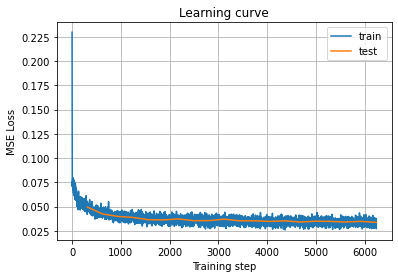

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(
    train_metrics["step"],
    train_metrics["loss"],
    label="train"
)
ax.plot(
    test_metrics["step"],
    test_metrics["loss"],
    label="test"
)
ax.set_xlabel("Training step")
ax.set_ylabel("MSE Loss")
ax.set_title("Learning curve")
ax.legend()
ax.grid()
plt.show()


## Analysing the results

Having trained the model we can now proceed to its analysis. As you can notice, we did not
 add an additional metric, as it was in case of the classification task. This time, we will
 perform analysis from three perspectives:

* how good did the model tackle reconstructing the input?
* is the model capable of generating examples using intermediate representation?
* how did the model place the encoded vectors in the latent space?


### Reconstruction analysis

Here we follow this path: we choose a subset of images from the validation dataset and
 push them through our trained autoencoder and then plot the results. This should let us
 see how good is the trained model at reconstructing the input.
 

In [25]:
from src.utils import AutoEncoderAnalyzer
import matplotlib.pyplot as plt


In [26]:
analyzer = AutoEncoderAnalyzer(
    model=model,
    dataset=test_dataset,
    n_samplings=1
)

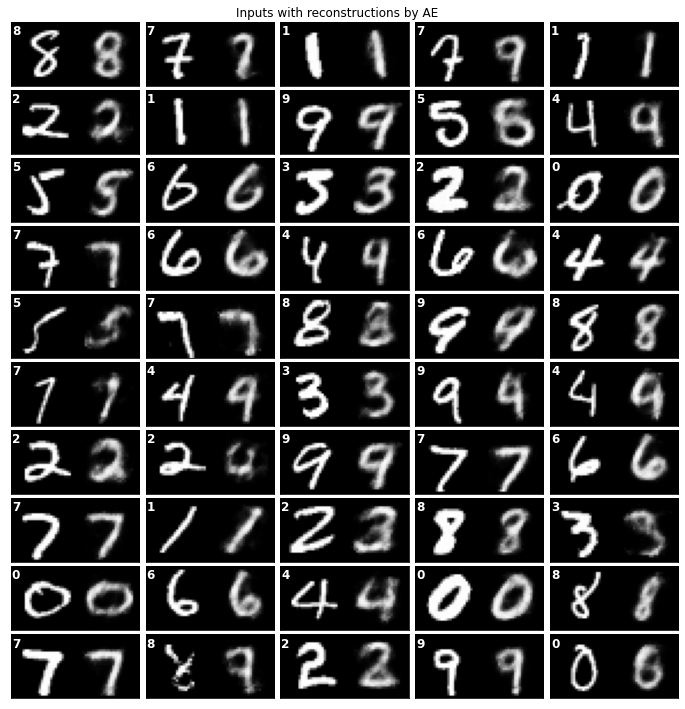

In [27]:
analyzer.compare_reconstruction_with_original()
plt.show()


### Generative capabilities

MNIST provides us with labels for each example, therefore we could try to use the labels
 to estimate the average representation for each digit. That could tell us what form
 did the model associate with each digit.
 

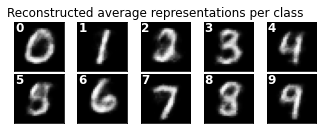

In [28]:
analyzer.average_points_per_class()
plt.show()


Furthermore, we could try to check how changes in latent vectors values influence the
 reconstructed image. Ideally, intermediate latent vectors, i.e. those, that are
 "between" the encoded latent representations, should produce realistic values as well,
 proving the latent space to be smooth - which is one of the crucial priors of representation learning, as stated in [2]).
 
> [[2] Bengio, Y., Courville, A., Vincent, P. *Representation Learning: A Review and New Perspectives*. 2013.](https://www.deeplearningbook.org/contents/autoencoders.html)

Digit: 0
Researching values in range [-1.0, 1.0]


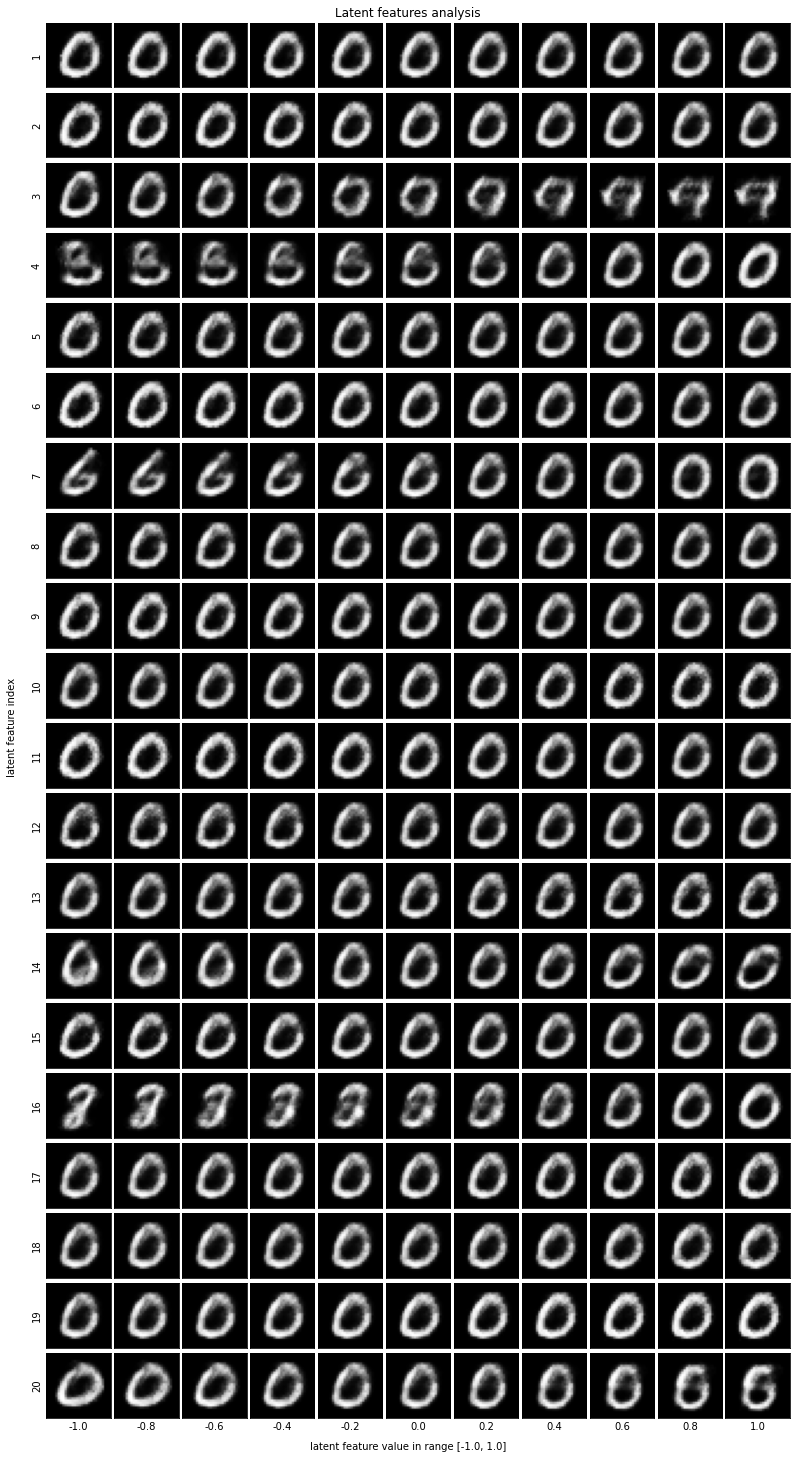

Digit: 1
Researching values in range [-1.0, 1.0]


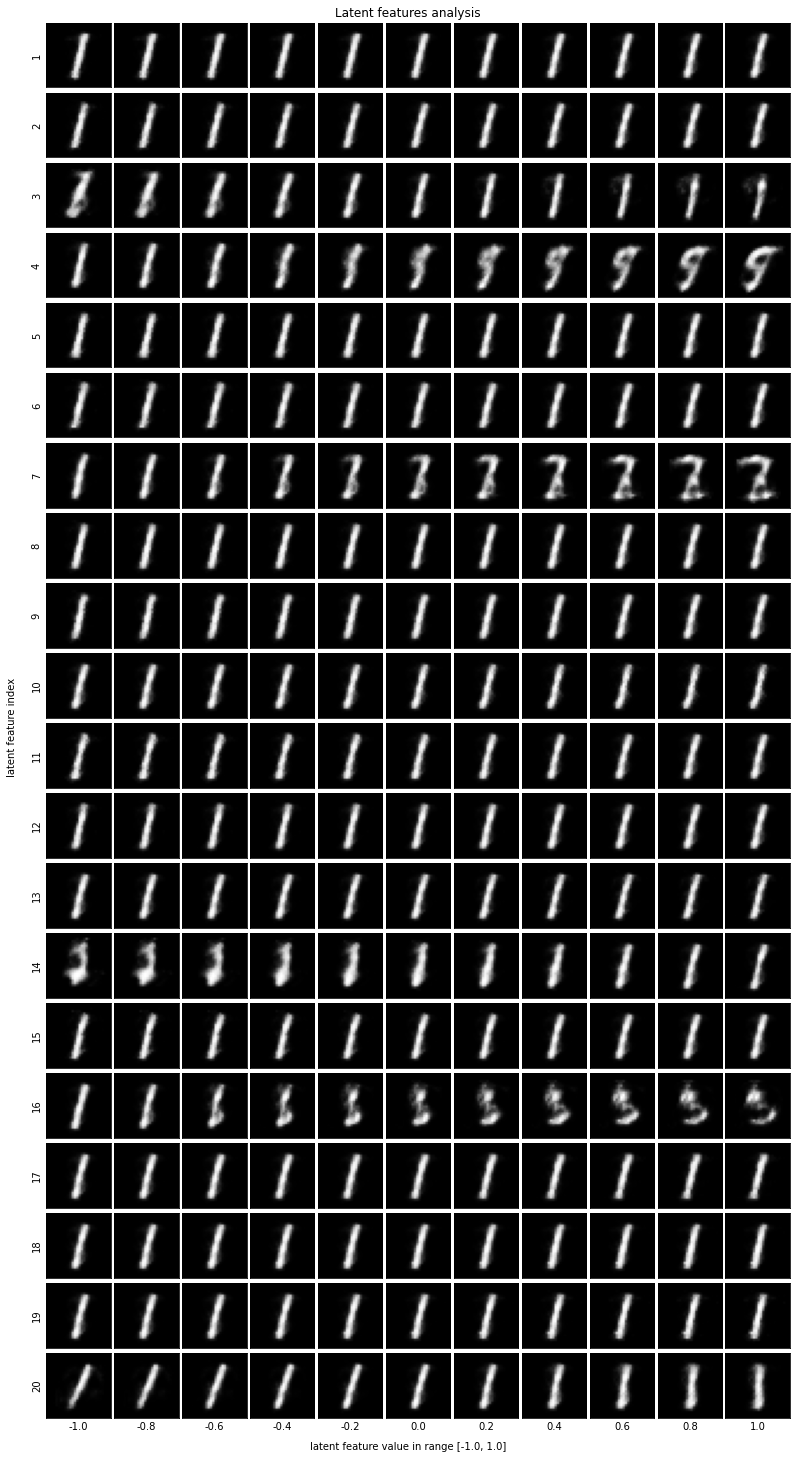

Digit: 2
Researching values in range [-1.0, 1.0]


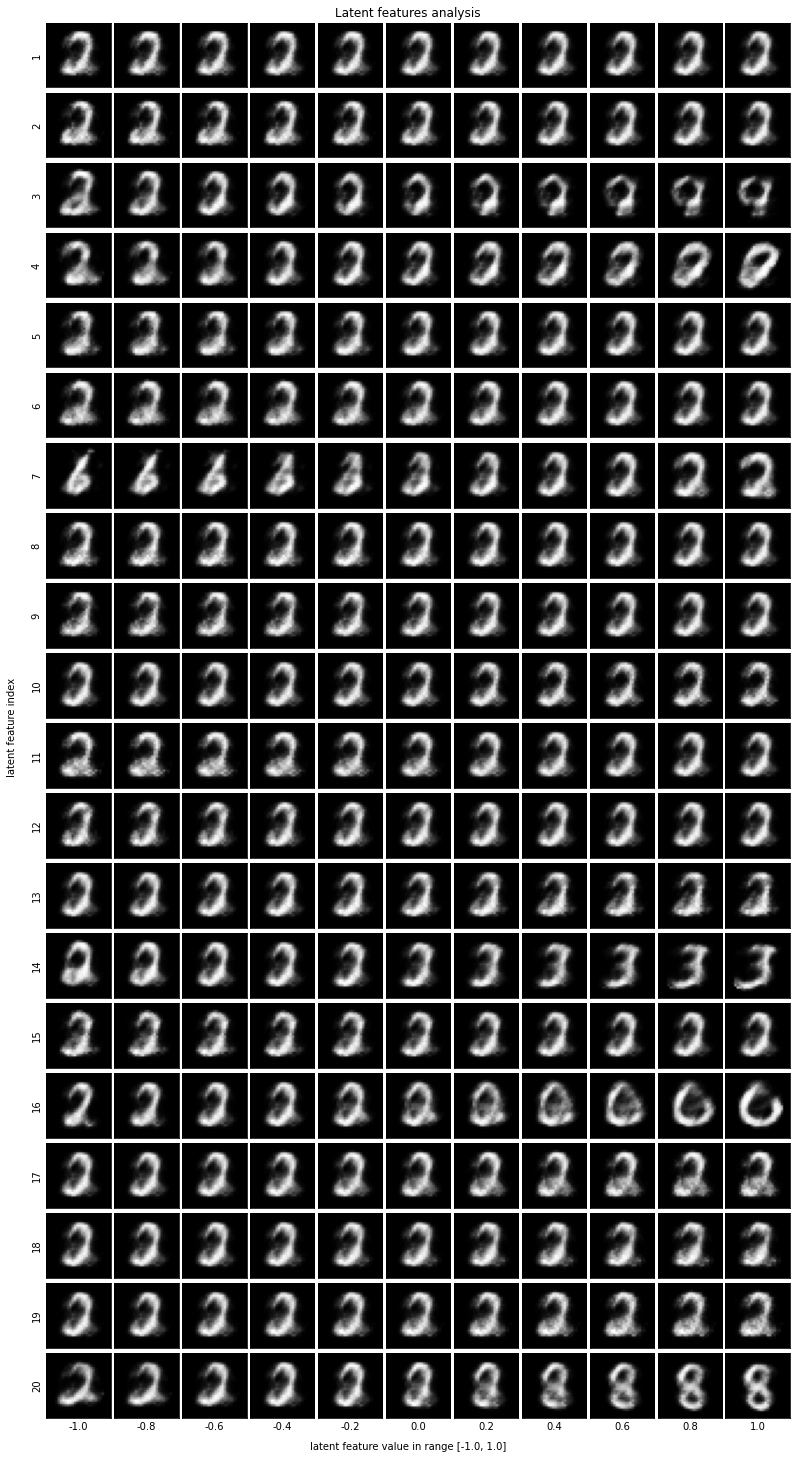

Digit: 3
Researching values in range [-1.0, 1.0]


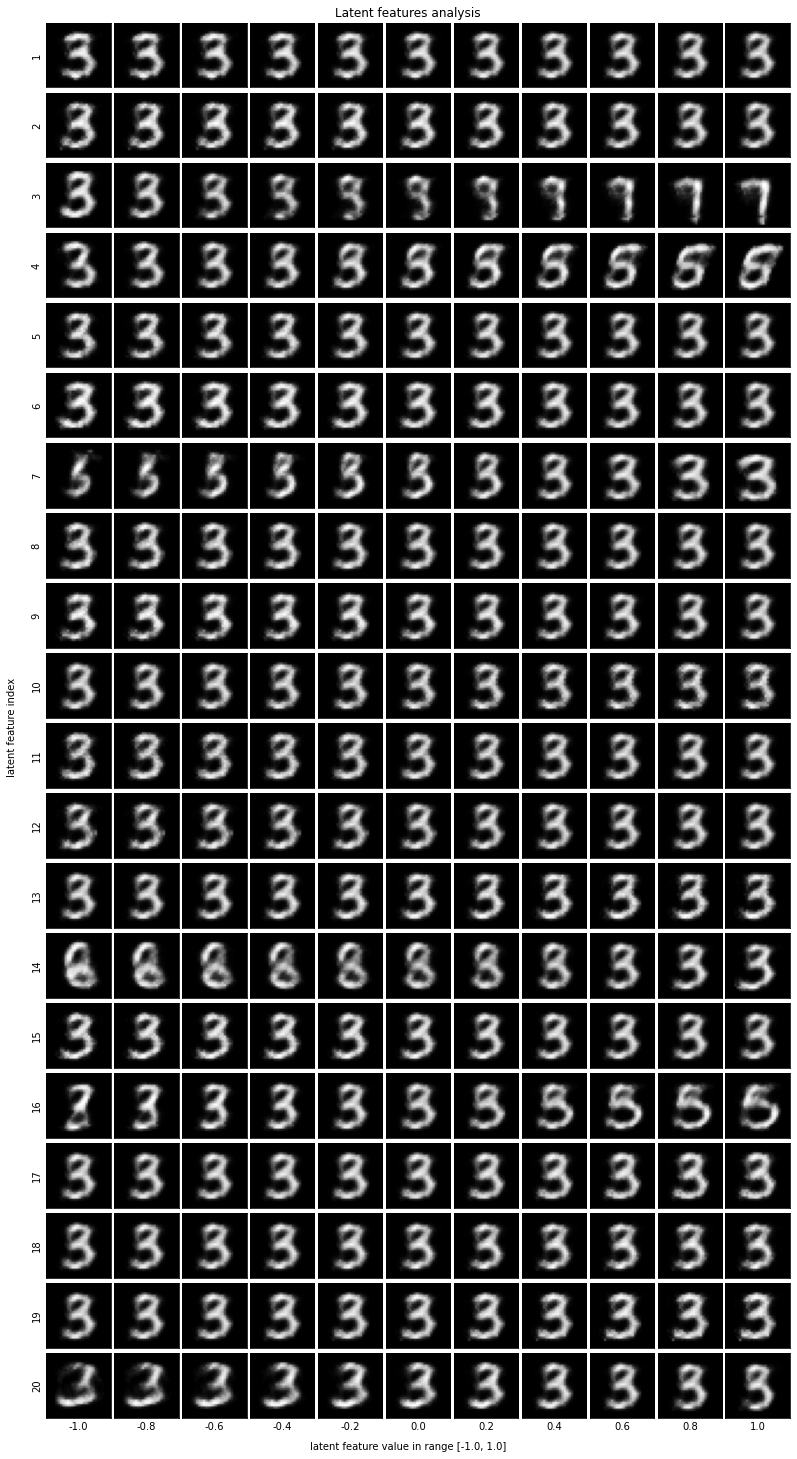

Digit: 4
Researching values in range [-1.0, 1.0]


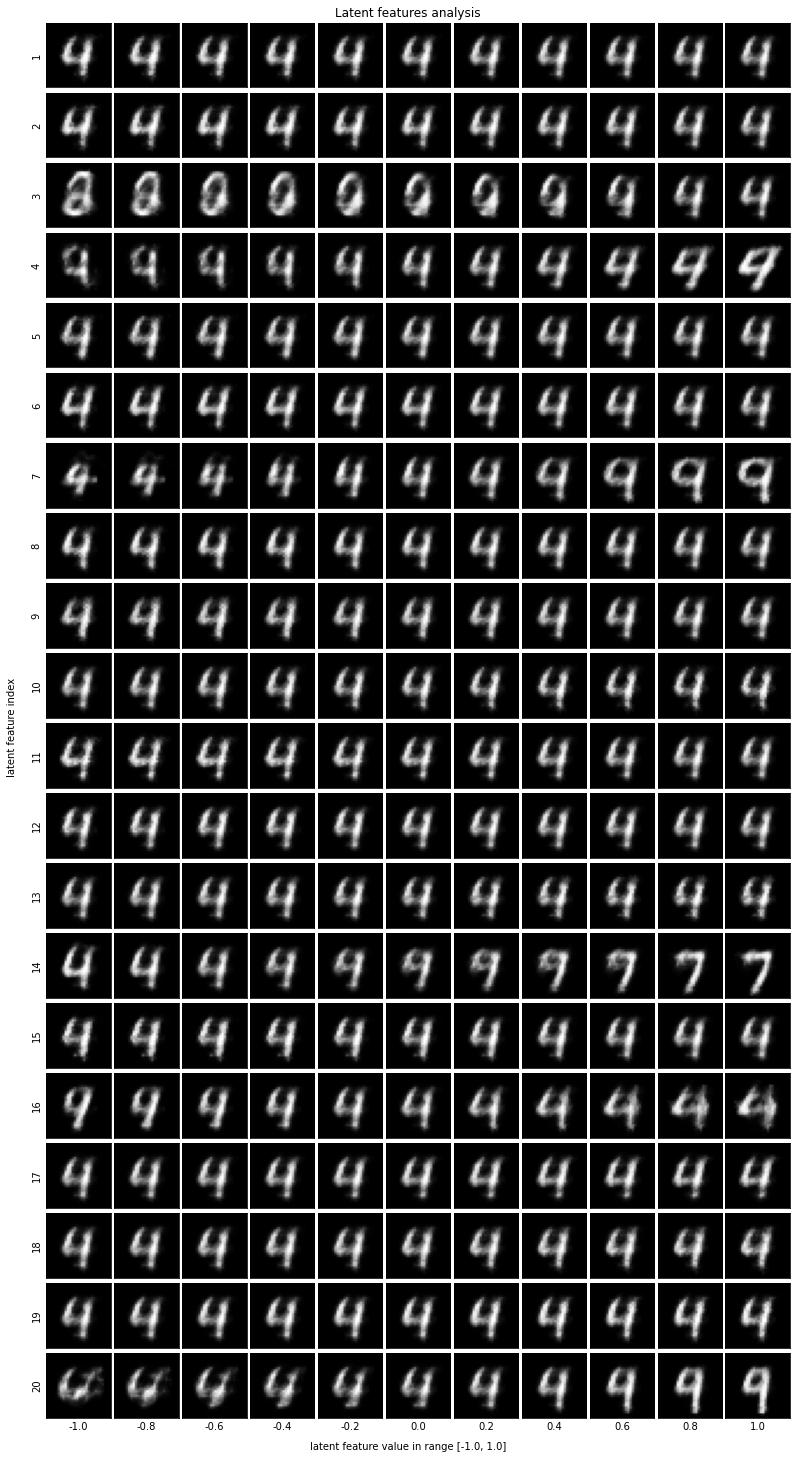

Digit: 5
Researching values in range [-1.0, 1.0]


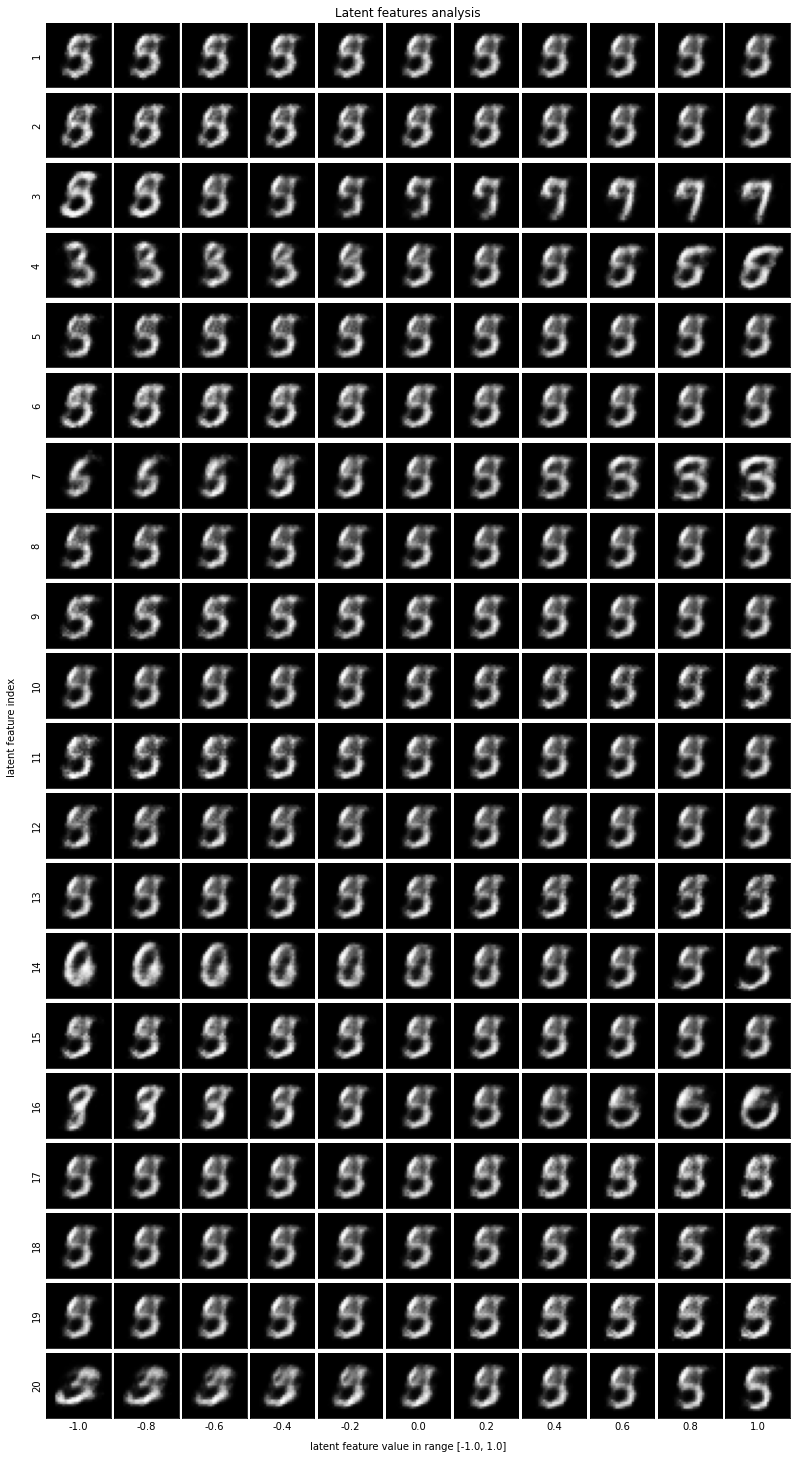

Digit: 6
Researching values in range [-1.0, 1.0]


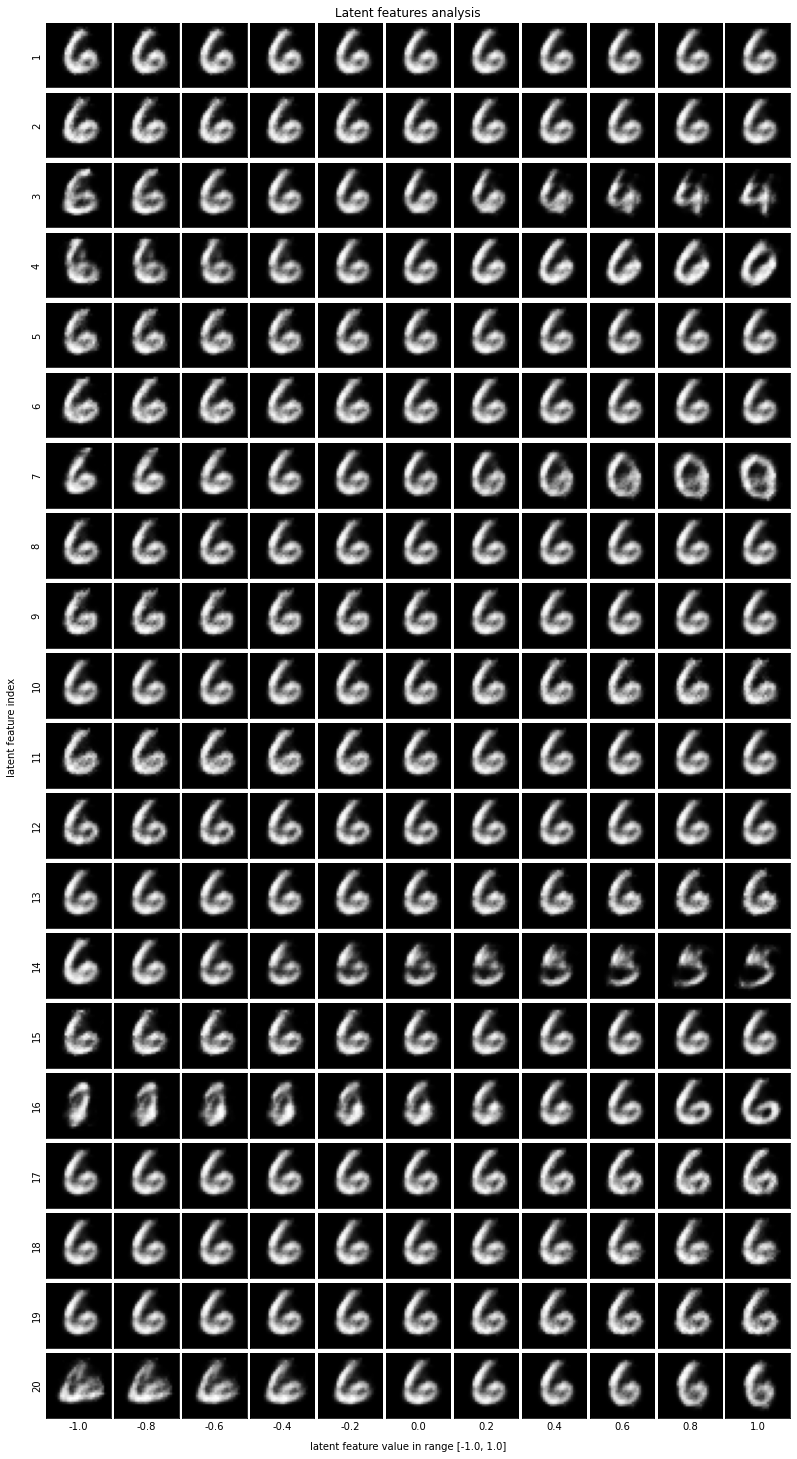

Digit: 7
Researching values in range [-1.0, 1.0]


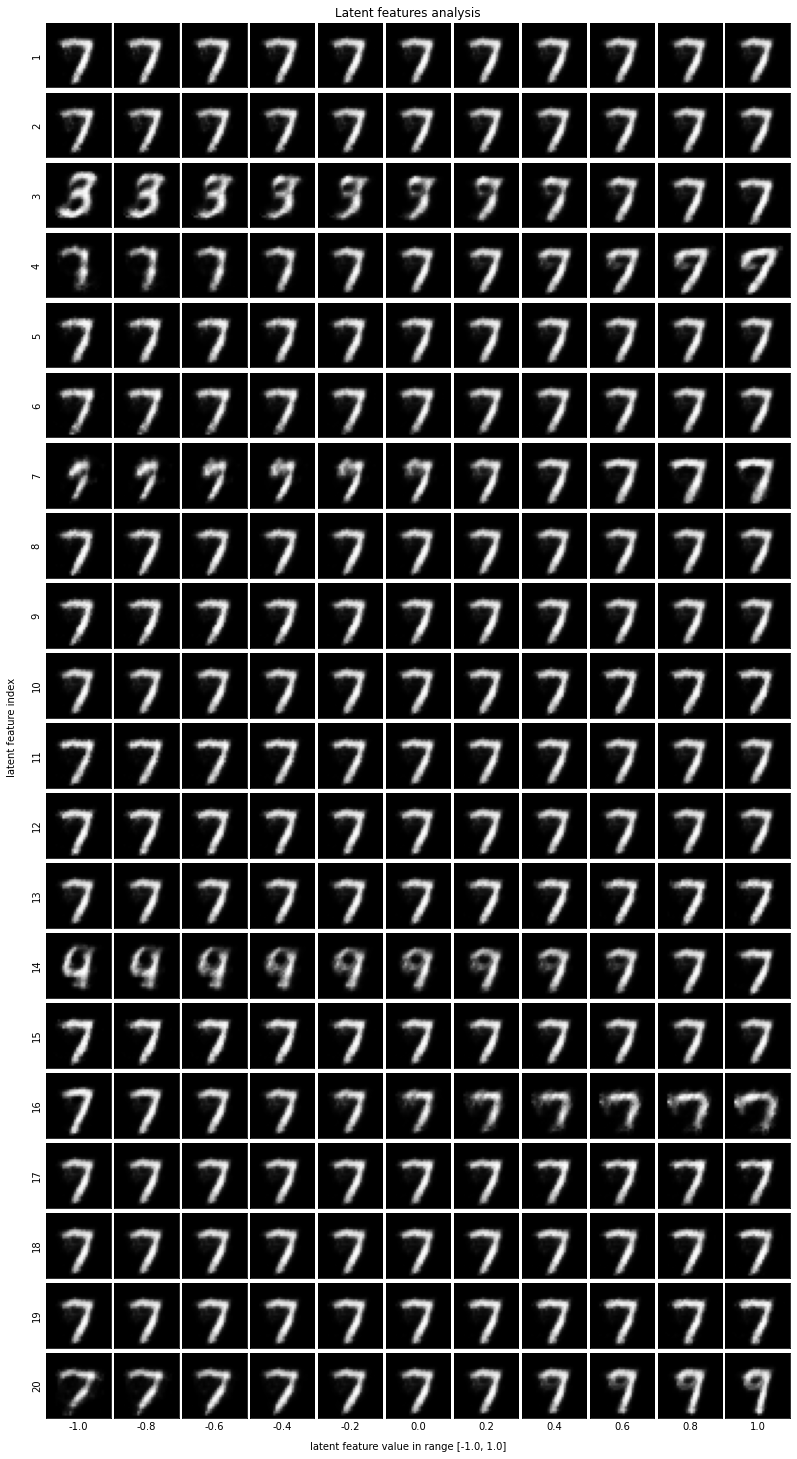

Digit: 8
Researching values in range [-1.0, 1.0]


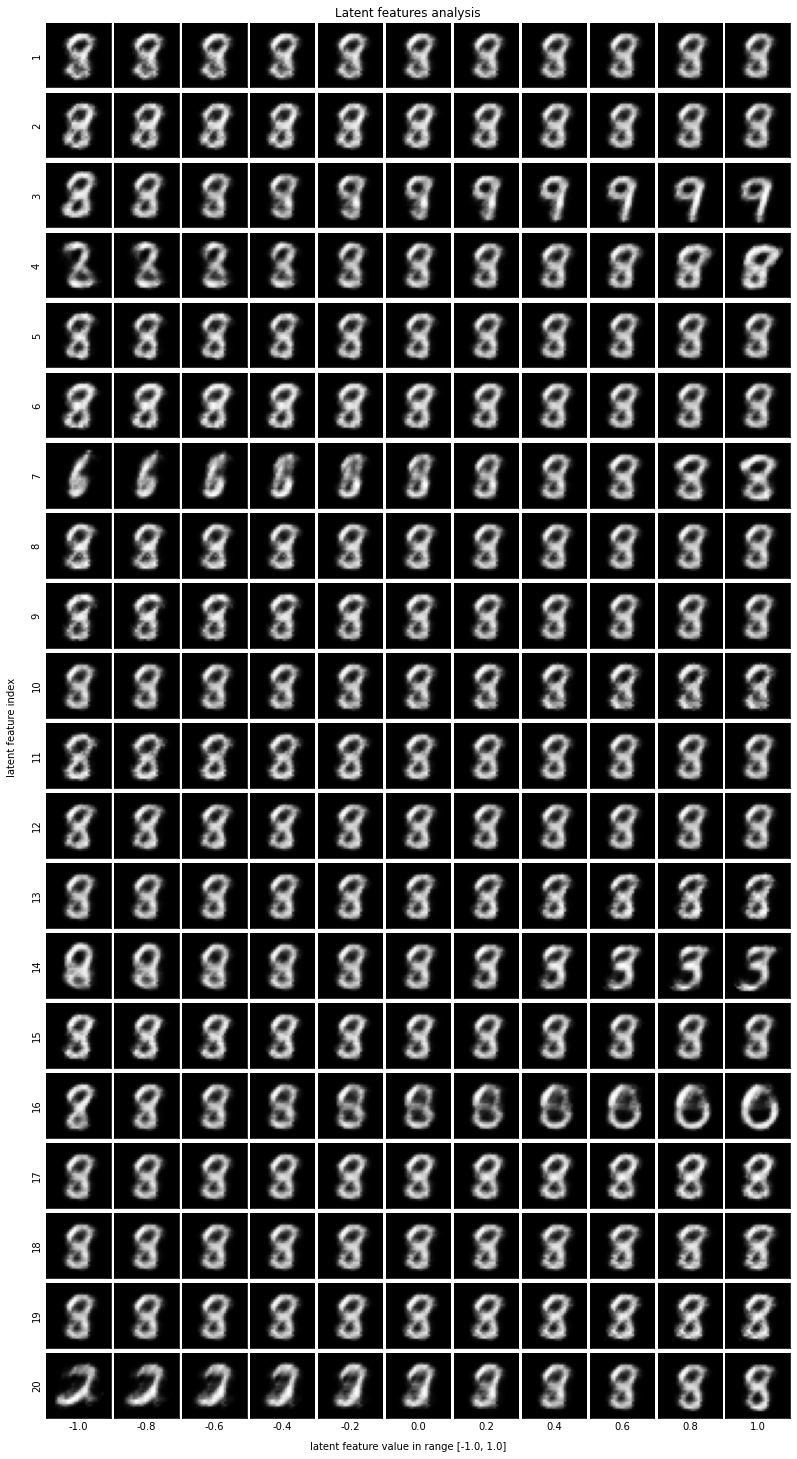

Digit: 9
Researching values in range [-1.0, 1.0]


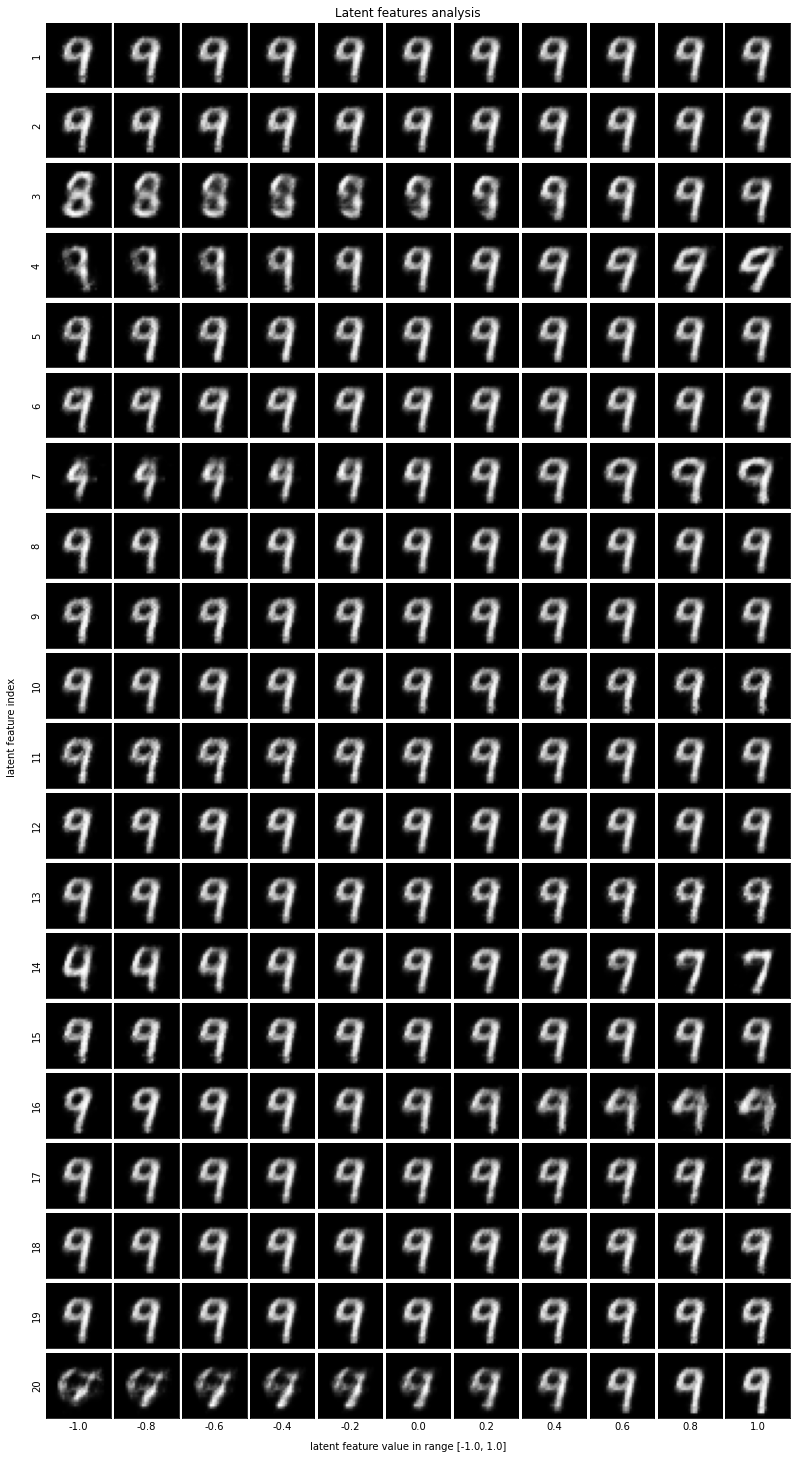

In [29]:
for digit, latent_code in enumerate(analyzer._averages):
    print(f"Digit: {digit}")
    analyzer.analyze_features(latent_code, steps=11)
    plt.show()


### Latent space representation

Hidden representation produced by our encoder network might be considered as a n-dimensional
 latent space of the entire dataset. Here we attempt an analysis of this space by encoding
 all images and embedding them into a 2-dimensional T-SNE space. This way we retrieve an insight
 on how our model perceive the data. On this basis we can infer which of them seem to be similar
 and which are diametrically opposed.

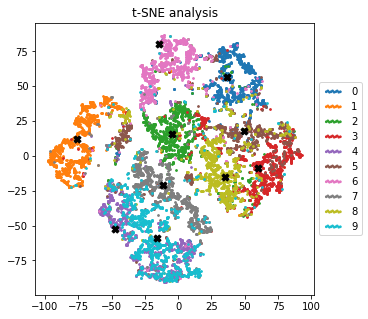

In [30]:
analyzer.analyze_tsne()  # this may take quite a long time
plt.show()
